In [22]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import imgaug.augmenters as iaa
import seaborn
import sys
sys.path.append('../Augmentation/')
import augmentations

from training_utils import get_net_optimiser_scheduler_criterion

In [12]:
path_networks='../Data/trained_networks/'
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
net, _, _, _ = get_net_optimiser_scheduler_criterion(device)

In [13]:
X = np.load('../Data/processed_data/finfets_imgs.npy', allow_pickle=True)
resizer = iaa.Resize([100, 100])

new_X = []
for element in X:
    el0 = resizer.augment_image(image=element[0])
    el1 = resizer.augment_image(image=element[1])
    im = augmentations.normalise([el0, el1])
    new_X.append(im)
X = np.array(new_X)

In [18]:
scan_to_classify = X[0]
scan_to_classify = scan_to_classify[np.newaxis]

In [19]:
predictions=[]

n_preds=10
for rep in range(n_preds):
    path_to_nn=path_networks+'only_simulator_rep_'+str(rep)+'.pth'
    
    if torch.cuda.is_available():
        net.load_state_dict(torch.load(path_to_nn))
    else:
        net.load_state_dict(torch.load(path_to_nn, map_location=torch.device('cpu')))
    net.eval()
    with torch.no_grad():

        outputs = net(torch.Tensor(scan_to_classify).to(device))
        activation=nn.Softmax(dim=1)
        preds=activation(outputs)[:,-1].detach().cpu().numpy()
        predictions.append(preds)
predictions = (np.sum(predictions, axis=0)/n_preds)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


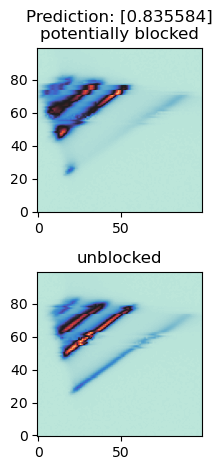

In [24]:
fig, axs = plt.subplots(2,1)
axs[0].imshow(scan_to_classify[0][0], origin='lower', cmap='icefire')
axs[0].set_title(f'Prediction: {predictions}\npotentially blocked')
axs[1].imshow(scan_to_classify[0][1], origin='lower', cmap='icefire')
axs[1].set_title('unblocked')
plt.tight_layout()
plt.show()